In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Dataset
%matplotlib inline

!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv



--2023-10-23 20:06:19--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.36M  --.-KB/s    in 0.08s   

2023-10-23 20:06:19 (17.5 MB/s) - ‘housing.csv’ saved [1423529/1423529]



In [ ]:
# Preparing the dataset
# For this homework, we only want to use a subset of data. This is the same subset we used in homework #2. But in contrast to homework #2, we are going to use all columns of the dataset.

# First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

# Preparation:

# Fill missing values with zeros.
# Apply the log transform to median_house_value.
# Do train/validation/test split with 60%/20%/20% distribution.
# Use the train_test_split function and set the random_state parameter to 1.
# Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

PATH = "./housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households",
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [ ]:
features = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households",
               "median_income", "ocean_proximity"]
train_dicts = df_train[features].to_dict(orient='records')
val_dicts = df_val[features].to_dict(orient='records')

In [ ]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [ ]:
# Question 1
# Let's train a decision tree regressor to predict the median_house_value variable.

# Train a model with max_depth=1.

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [ ]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



In [ ]:
# Question 2

# Train a random forest model with these parameters:

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [ ]:
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

0.24566012875324933

In [ ]:
# Question 3

# Now, let's experiment with the n_estimators parameter.

scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))

    scores.append((n, score))

  0%|          | 0/20 [00:00<?, ?it/s]

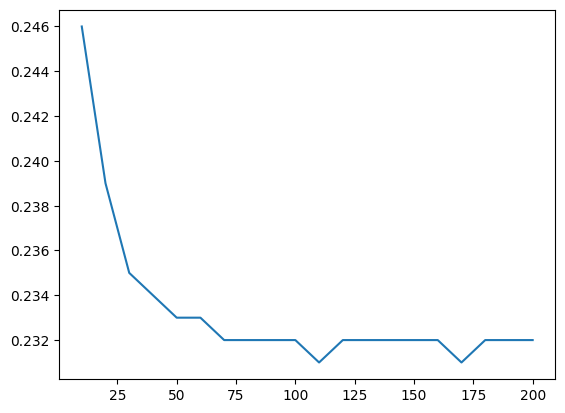

In [ ]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))
plt.show()

In [ ]:
# Question 4

# Let's select the best max_depth:

scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

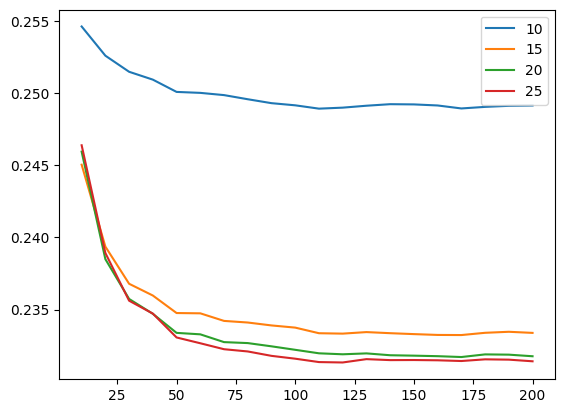

In [ ]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

In [ ]:
# Question 5

# We can extract feature importance information from tree-based models.

# At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

# In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

# For this homework question, we'll find the most important feature:

# Train the model with these parametes:

rf = RandomForestRegressor(n_estimators=10, max_depth=20,
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [ ]:
rf.feature_importances_

array([1.63873827e-02, 3.31454580e-02, 1.01255849e-01, 9.64702137e-02,
       3.63325843e-01, 2.48880276e-03, 3.10900842e-01, 3.56806263e-04,
       4.80369796e-04, 4.69876693e-03, 3.07769212e-02, 1.91716318e-02,
       2.05411131e-02])

In [ ]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances

,feature,importance
0,households,0.016387
1,housing_median_age,0.033145
2,latitude,0.101256
3,longitude,0.096470
4,median_income,0.363326
5,ocean_proximity=<1H OCEAN,0.002489
6,ocean_proximity=INLAND,0.310901
7,ocean_proximity=ISLAND,0.000357
8,ocean_proximity=NEAR BAY,0.000480
9,ocean_proximity=NEAR OCEAN,0.004699


In [ ]:

df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
4,median_income,0.363326
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101256
3,longitude,0.096470
1,housing_median_age,0.033145


In [ ]:
# Question 6
#
# Now let's train an XGBoost model! For this question, we'll tune the eta parameter:
#
# Install XGBoost.
# Create DMatrix for train and validation
# Create a watchlist
# Train a model with these parameters for 100 rounds:

In [ ]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

In [ ]:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [ ]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [ ]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))

    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [ ]:
scores['eta=0.3'] = parse_xgb_output(output)

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [ ]:

scores['eta=0.1'] = parse_xgb_output(output)

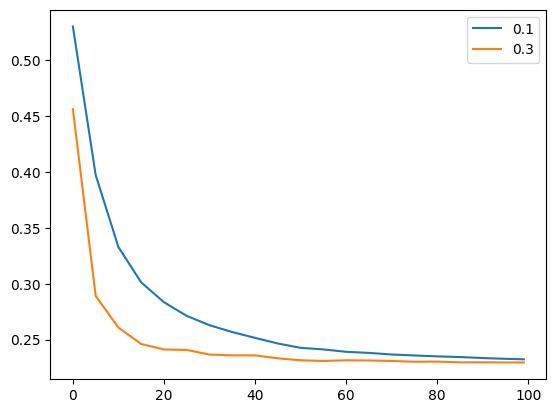

In [ ]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()
plt.show()